<h1 style="color:#FF00A6; font-weight:bold; font-family:sans-serif;">
  Snappfood Data Analyst Task
</h1>

<h3 style="color:#F9FAFB; font-family:sans-serif;">
  Task 1 – <em>Restaurant Assignment</em>
</h3>

<p style="color:#EBEDF0; font-size:14px; font-family:sans-serif;">
  Assign restaurants to 5 data collectors to minimize total travel distance based on their coordinates.
</p>
<br>
<hr style="color:#FF00A6;">

# Imports & Setup

In [110]:
# Import the importlib module to check if the required libraries are installed
import importlib.util

# List of required libraries
required_libraries = ['requests', 'pandas', 'numpy', 'matplotlib', 'scikit-learn', 'networkx', 'scipy']

# Install the required libraries if they are not already installed
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        %pip install {lib}

import requests
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.metrics import silhouette_score
from networkx.algorithms.approximation import greedy_tsp


Note: you may need to restart the kernel to use updated packages.


# Prepare Dataset

## Download from Google Sheets

In [9]:
def download_sheet_as_csv(spreadsheet_id, gid, output_path):
    url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export"
    params = {
        "format": "csv",
        "gid": gid
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        with open(output_path, "wb") as f:
            f.write(response.content)
        print(f"Sheet downloaded and saved to '{output_path}'")
    else:
        print(f"Failed to download sheet. Status code: {response.status_code}")

# Replace with your actual spreadsheet ID and sheet GID
SPREADSHEET_ID = "1ic4RLD_r4ASfl7nRk2ctagH_98j2sPDYN7IB4n6n9e8"
GID = "0"  # GID of Task 1 sheet
OUTPUT_FILE = "./task1_dataset.csv"

download_sheet_as_csv(SPREADSHEET_ID, GID, OUTPUT_FILE)


Sheet downloaded and saved to './task1_dataset.csv'


## Load Dataset

In [12]:
df = pd.read_csv("./task1_dataset.csv")

# Preview
df.head()


,Feature_1,Feature_2
0,1.843183,1.314703
1,1.781859,0.925744
2,0.806028,-2.324464
3,-0.180512,0.555683
4,0.741876,-2.115367


# Clustering

In [129]:
# Utility: Estimate TSP route distance (Euclidean)
def estimate_tsp_distance(coords):
    if len(coords) <= 1:
        return 0.0
    dist_matrix = distance_matrix(coords, coords)
    G = nx.complete_graph(len(coords))
    for i in G.nodes:
        for j in G.nodes:
            if i != j:
                G[i][j]['weight'] = dist_matrix[i][j]
    tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=False, method=greedy_tsp)
    return sum(dist_matrix[tsp_path[i], tsp_path[i+1]] for i in range(len(tsp_path)-1))


In [130]:
# Utility: Report for clustering methods
def report_cluster_stats(df, label_col, centroids=None):
    """
    Prints:
    - Cluster sizes
    - Sum of distances to centroid per cluster
    - TSP route distances per cluster
    - Returns totals for both distance types
    """
    label_shifted = df[label_col] + 1
    df[f'{label_col}_person'] = label_shifted
    cluster_counts = label_shifted.value_counts().sort_index()

    print(f"Cluster Size Breakdown ({label_col}):")
    print(cluster_counts)

    print(f"\nSum of Distances to Centroid per Person ({label_col}):")
    total_centroid_dists = []
    for i in range(1, 6):
        cluster = df[df[f'{label_col}_person'] == i][['Feature_1', 'Feature_2']]
        if centroids is not None:
            centroid = centroids[i - 1].reshape(1, -1)
        else:
            centroid = cluster.mean().values.reshape(1, -1)
        dist = np.linalg.norm(cluster.values - centroid, axis=1).sum()
        total_centroid_dists.append(dist)
        print(f"Person {i}: {dist:.2f} units")

    total_centroid_sum = sum(total_centroid_dists)
    print(f"\nTotal Sum of Distances to Centroids: {total_centroid_sum:.2f} units")

    print(f"\nTSP Route Distance per Person ({label_col}):")
    tsp_dists = []
    for i in range(1, 6):
        cluster_coords = df[df[f'{label_col}_person'] == i][['Feature_1', 'Feature_2']].values
        tsp_distance = estimate_tsp_distance(cluster_coords)
        tsp_dists.append(tsp_distance)
        print(f"Person {i}: {tsp_distance:.2f} units")

    total_tsp = sum(tsp_dists)
    print(f"\nTotal TSP Route Distance: {total_tsp:.2f} units")

    tsp_std = np.std(tsp_dists)

    return {
        'counts': cluster_counts,
        'centroid_dists': total_centroid_dists,
        'centroid_total': total_centroid_sum,
        'tsp_dists': tsp_dists,
        'tsp_total': total_tsp,
        'tsp_std': tsp_std
    }


## Raw Coordinates

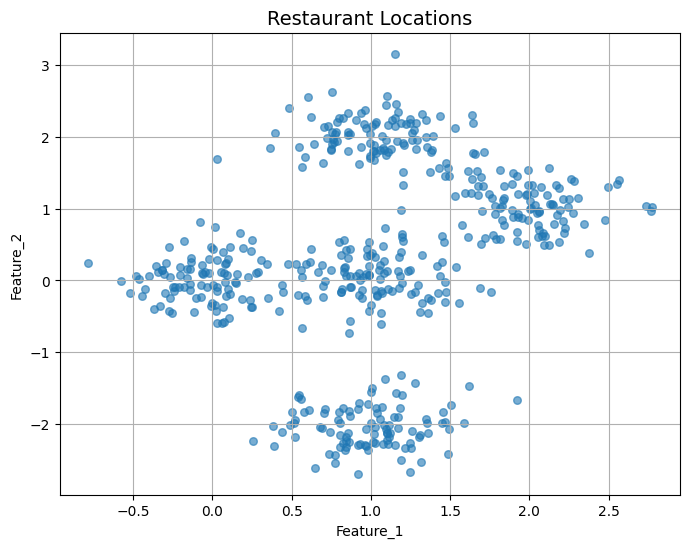

In [131]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Feature_1'], df['Feature_2'], alpha=0.6, s=30)
plt.title("Restaurant Locations", fontsize=14)
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.grid(True)
plt.show()


## KMeans Clustering

In [132]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_label'] = kmeans.fit_predict(df[['Feature_1', 'Feature_2']])
kmeans_centroids = kmeans.cluster_centers_

# Remap label from 0–4 to 1–5 for readability
df['kmeans_person'] = df['kmeans_label'] + 1


### Visualize Clusters

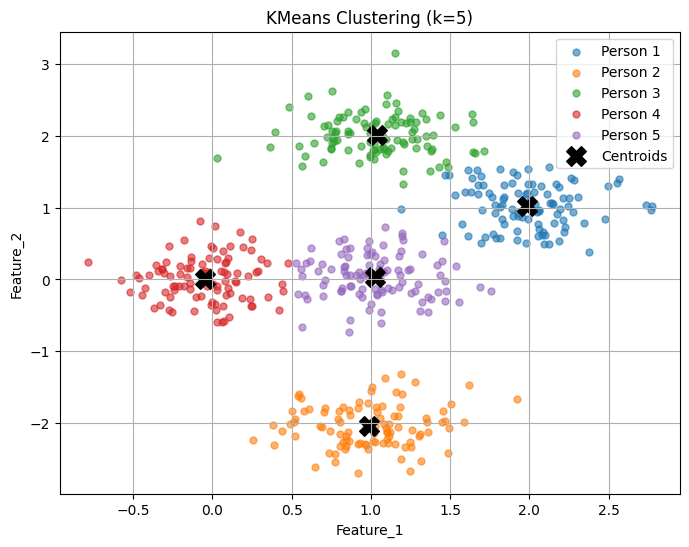

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(1, 6):
    cluster = df[df['kmeans_person'] == i]
    plt.scatter(cluster['Feature_1'], cluster['Feature_2'], s=25, label=f'Cluster {i}', alpha=0.6)

plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title("KMeans Clustering (k=5)")
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.legend()
plt.grid(True)
plt.show()


### Report

In [134]:
print("=== KMEANS CLUSTERING REPORT ===")
kmeans_stats = report_cluster_stats(df, 'kmeans_label', centroids=kmeans_centroids)


=== KMEANS CLUSTERING REPORT ===
Cluster Size Breakdown (kmeans_label):
kmeans_label
1     99
2    100
3    101
4     98
5    102
Name: count, dtype: int64

Sum of Distances to Centroid per Person (kmeans_label):
Person 1: 36.57 units
Person 2: 37.47 units
Person 3: 36.60 units
Person 4: 34.09 units
Person 5: 37.03 units

Total Sum of Distances to Centroids: 181.76 units

TSP Route Distance per Person (kmeans_label):
Person 1: 10.56 units
Person 2: 11.44 units
Person 3: 12.68 units
Person 4: 10.33 units
Person 5: 10.89 units

Total TSP Route Distance: 55.89 units


## Agglomerative Clustering

In [135]:
agglo = AgglomerativeClustering(n_clusters=5, linkage='ward')
df['agglo_label'] = agglo.fit_predict(df[['Feature_1', 'Feature_2']])


### Visualize Clusters

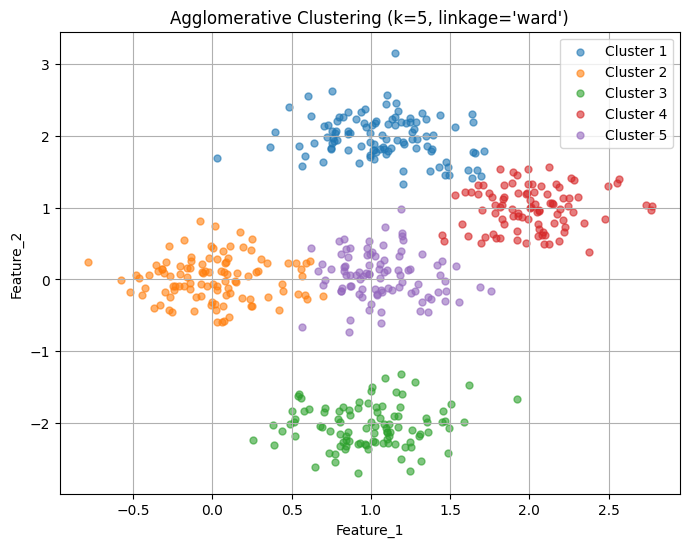

In [136]:
plt.figure(figsize=(8, 6))
for i in range(5):
    cluster = df[df['agglo_label'] == i]
    plt.scatter(cluster['Feature_1'], cluster['Feature_2'], s=25, label=f'Cluster {i+1}', alpha=0.6)

plt.title("Agglomerative Clustering (k=5, linkage='ward')")
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.legend()
plt.grid(True)
plt.show()


### Report

In [137]:
print("\n=== AGGLOMERATIVE CLUSTERING REPORT ===")
agglo_stats = report_cluster_stats(df, 'agglo_label')



=== AGGLOMERATIVE CLUSTERING REPORT ===
Cluster Size Breakdown (agglo_label):
agglo_label
1    107
2    107
3    100
4     93
5     93
Name: count, dtype: int64

Sum of Distances to Centroid per Person (agglo_label):
Person 1: 41.16 units
Person 2: 40.05 units
Person 3: 37.47 units
Person 4: 32.72 units
Person 5: 32.95 units

Total Sum of Distances to Centroids: 184.34 units

TSP Route Distance per Person (agglo_label):
Person 1: 13.37 units
Person 2: 11.05 units
Person 3: 11.44 units
Person 4: 9.47 units
Person 5: 10.53 units

Total TSP Route Distance: 55.87 units


# Evaluation

In [138]:
def evaluate_clustering(df, label_col, method_name, stats):
    labels = df[label_col].values
    unique_labels = np.unique(labels)

    # Silhouette Score
    silhouette = silhouette_score(df[['Feature_1', 'Feature_2']], labels) if len(unique_labels) > 1 else np.nan

    # Cluster size balance (from stats)
    size_std = stats['counts'].std()

    return {
        'Method': method_name,
        'Silhouette': silhouette,
        'Total Centroid Distance': stats['centroid_total'],
        'Total TSP Distance': stats['tsp_total'],
        'TSP StdDev': stats['tsp_std'],
        'Size StdDev': size_std
    }


In [139]:
# Use those stats in the evaluation
eval_kmeans = evaluate_clustering(df, 'kmeans_label', 'KMeans', kmeans_stats)
eval_agglo = evaluate_clustering(df, 'agglo_label', 'Agglomerative', agglo_stats)

# Create and display comparison table
eval_df = pd.DataFrame([eval_kmeans, eval_agglo]).set_index('Method')
display(eval_df)


,Silhouette,Total Centroid Distance,Total TSP Distance,TSP StdDev,Size StdDev
Method,,,,,
KMeans,0.596685,181.764733,55.888486,0.837515,1.581139
Agglomerative,0.585019,184.344327,55.867158,1.283021,7.000000


# Final Report

## Best Method

In [140]:
# Manually select the best method here
best_method = 'KMeans'
label_col = 'kmeans_label'
centroids = kmeans_centroids


## Clustering Map

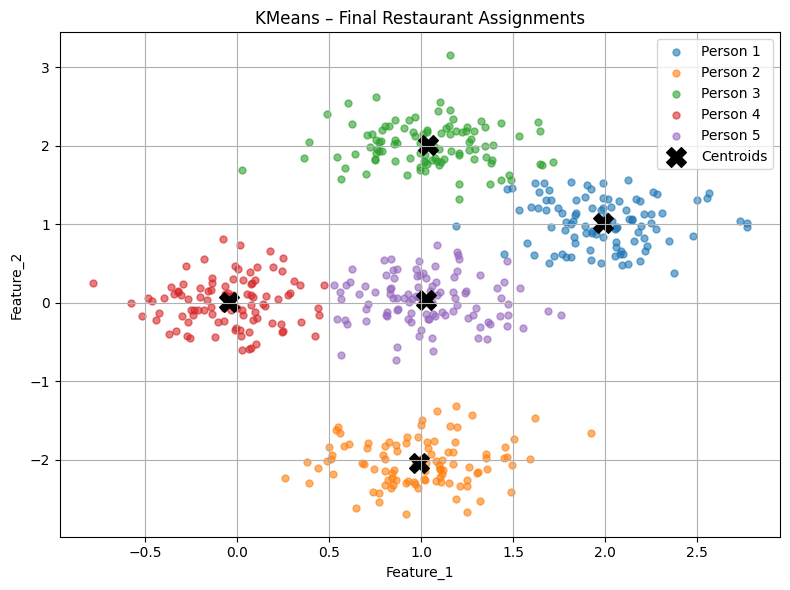

In [ ]:
# Add 1-based person label for clean output
df['person'] = df[label_col] + 1

plt.figure(figsize=(8, 6))
for i in range(1, 6):
    cluster = df[df['person'] == i]
    plt.scatter(cluster['Feature_1'], cluster['Feature_2'], s=25, label=f'Person {i}', alpha=0.6)

if centroids is not None:
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

plt.title(f"{best_method} – Final Restaurant Assignments")
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Stats

In [143]:
stats = report_cluster_stats(df, label_col, centroids=centroids)


Cluster Size Breakdown (kmeans_label):
kmeans_label
1     99
2    100
3    101
4     98
5    102
Name: count, dtype: int64

Sum of Distances to Centroid per Person (kmeans_label):
Person 1: 36.57 units
Person 2: 37.47 units
Person 3: 36.60 units
Person 4: 34.09 units
Person 5: 37.03 units

Total Sum of Distances to Centroids: 181.76 units

TSP Route Distance per Person (kmeans_label):
Person 1: 10.56 units
Person 2: 11.44 units
Person 3: 12.68 units
Person 4: 10.33 units
Person 5: 10.89 units

Total TSP Route Distance: 55.89 units


# Save Dataset

In [145]:
df_final = df[['Feature_1', 'Feature_2', 'person']].copy()

# Export to CSV
df_final.to_csv("./task1_final_assignment.csv", index=False)
print("Final dataset saved with 'person' column.")


Final dataset saved with 'person' column.
